# Amortized probabilistic models for chemical microscopy

### Can we used an amortized model to speed up inference in our droplet microscopy model?

My last go using a probabilistic model to analyze a microscope image seemed to work well enough, but I wanted to take a more flexible approach to modelling the appearance of droplets without having to roll out a more sophisticated physical model. Also, it seemed impractical to require a beefy GPU and minutes of compute for a single image.

I've been meaning to experiment with *amortized* inference a bit more recently. The idea is that instead of all latent variables being inferred, a small model (think a miniature multi-layer perceptron) is trained to predict a subset of these variables. We are interested in inferring droplet locations and compositions, not so much about rendering the droplets themselves. This approach can give the best of both worlds, a mechanistic interpretable model for the parts that we care about or are easy to reason about, and an data-driven, learned representation for the complex, inherently introspectable parts.

In [1]:
import jax
import jax.numpy as jnp
import jax.nn as jnn
import flax.linen as nn
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import seaborn as sns
from numpyro import deterministic, plate, sample
from numpyro.handlers import seed, trace, substitute
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS
from numpyro.infer.autoguide import AutoNormal
from numpyro.optim import Adam
from PIL import Image

plt.rcParams['figure.dpi'] = 200

sns.set_theme(context='paper', style='ticks', font='Arial')

We'll use the same delightful microscope image as last time, part of the experiments that went into our [latest paper](https://doi.org/10.1039/D5DD00100E).

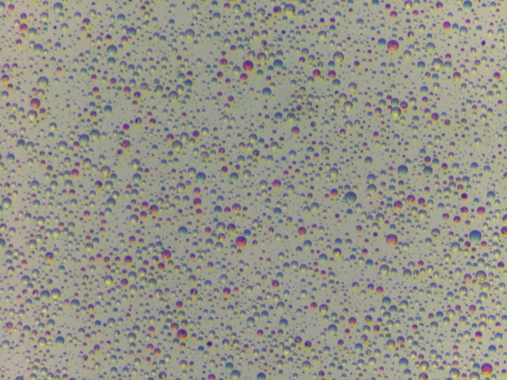

In [2]:
img = Image.open('data/example.jpg')
img = img.resize((img.width // 4, img.height // 4))
img

In [3]:
img = np.array(img) / 255.0

In [ ]:
class DropletOpticsModel(nn.Module):
    hidden_dims: tuple = (32, 16, 8)
    
    @nn.compact
    def __call__(self, background, dx, dy, radius, composition):
        """
        Args:
            background: (batch, n_channels) - existing/background pixel values
            dx: (batch, 1) - normalized distance from droplet center in x-direction
            dy: (batch, 1) - normalized distance from droplet center in y-direction
            radius: (batch, 1) - droplet radius
            composition: (batch, n_composition_features) - droplet composition vector
        
        Returns:
            new_pixel_value: (batch, n_channels) - predicted new pixel values
        """
        # Concatenate all input features
        x = jnp.concatenate([background, dx, dy, radius, composition], axis=-1)

        for i, dim in enumerate(self.hidden_dims):
            x = nn.Dense(dim, name=f'hidden_{i}')(x)
            x = nn.LayerNorm(name=f'ln_{i}')(x)
            x = jnn.relu(x)
        
        # Output layer - predict change in pixel values
        delta = nn.Dense(background.shape[-1], name='output')(x)
        
        # Add residual connection and apply sigmoid to keep values in [0, 1]
        new_pixel_value = jnn.sigmoid(background + delta)
        
        return new_pixel_value

# Initialize model
model = DropletOpticsModel()

# Test with dummy data
key = jax.random.PRNGKey(42)
batch_size, n_channels, n_composition = 32, 3, 10

dummy_background = jax.random.uniform(key, (batch_size, n_channels))
dummy_dx = jax.random.uniform(key, (batch_size, 1), minval=-1.0, maxval=1.0)
dummy_dy = jax.random.uniform(key, (batch_size, 1), minval=-1.0, maxval=1.0)
dummy_radius = jax.random.uniform(key, (batch_size, 1)) * 0.1  # Small radii
dummy_composition = jax.random.uniform(key, (batch_size, n_composition))

# Initialize parameters
print(f"{dummy_background.shape=}, {dummy_dx.shape=}, {dummy_dy.shape=}, {dummy_radius.shape=}, {dummy_composition.shape=}")
params = model.init(key, dummy_background, dummy_dx, dummy_dy, dummy_radius, dummy_composition)

# Test forward pass
output = model.apply(params, dummy_background, dummy_dx, dummy_dy, dummy_radius, dummy_composition)
print(f"Input background shape: {dummy_background.shape}")
print(f"Output pixel values shape: {output.shape}")
print(f"Output range: [{output.min():.3f}, {output.max():.3f}]")

# Print model summary
print(f"\nModel summary:")
print(model.tabulate(key, dummy_background, dummy_dx, dummy_dy, dummy_radius, dummy_composition))

dummy_background.shape=(32, 3), dummy_dx.shape=(32, 1), dummy_dy.shape=(32, 1), dummy_radius.shape=(32, 1), dummy_composition.shape=(32, 10)
Input background shape: (32, 3)
Output pixel values shape: (32, 3)
Output range: [0.260, 0.897]

Model summary:

                           DropletOpticsModel Summary                           
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path     ┃ module         ┃ inputs         ┃ outputs        ┃ params         ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│          │ DropletOptics… │ -              │ float32[32,3]  │                │
│          │                │ float32[32,3]  │                │                │
│          │                │ -              │                │                │
│          │                │ float32[32,1]  │                │                │
│          │                │ -              │                │                │
│          │     

What ended up working in the end is when each pixel refers to its closest droplet for colour. Not ideal but it keeps the memory requirement manageable.

In [5]:
def tree_to_dists(tree, path=''):
    if isinstance(tree, dict):
        return {k: tree_to_dists(v, path + '/' + k) for k, v in tree.items()}
    else:
        # print(f"Sampling {path} with shape {tree.shape}")
        return sample(path, dist.Normal().expand(tree.shape))

In [6]:
def model_with_nn(img, n_droplets, types=10):
    h, w, n_channels = img.shape
    
    # Create coordinate grids
    y_coords, x_coords = jnp.mgrid[:h, :w]
    
    # Sample background per channel
    with plate("channels", n_channels):
        bg = sample("bg", dist.Uniform(0, 1).expand((n_channels,)))

    # Sample droplet parameters
    with plate("droplets", n_droplets):
        x = sample("x", dist.Uniform(0, w))
        y = sample("y", dist.Uniform(0, h))
        r = sample("r", dist.LogNormal(0, 0.5))
        with plate("types", types):
            composition = sample("composition", dist.Uniform(0, 1)).T

    model = DropletOpticsModel()

    # Initialize background image
    prediction = jnp.broadcast_to(bg, (h, w, n_channels))
    nn_params = model.init(key, 
                           jnp.zeros((h * w, n_channels)), 
                           jnp.zeros((h * w, 1)),
                           jnp.zeros((h * w, 1)),
                           jnp.zeros((h * w, 1)),
                           jnp.zeros((h * w, types)))    
    nn_params = tree_to_dists(nn_params, path='nn_params')

    distance = ((x_coords[..., None] - x) / r)**2 + ((y_coords[..., None] - y) / r)**2
    nearest = jnp.argmin(distance, axis=-1)

    # Calculate relative distances from droplet center
    dx = (x_coords - x[nearest]) / r[nearest]  # Normalized by radius
    dy = (y_coords - y[nearest]) / r[nearest]  # Normalized by radius


    # Flatten spatial dimensions for neural network processing
    dx_flat = dx.flatten()[:, None]
    dy_flat = dy.flatten()[:, None]
    r_flat = r[nearest].flatten()[:, None]

    
    # Repeat background and composition for all pixels
    bg_flat = prediction.reshape(-1, n_channels)
    comp_flat = composition[nearest, :].reshape(-1, types)
    
    # Apply neural network to get new pixel values
    prediction = model.apply(nn_params, bg_flat, dx_flat, dy_flat, r_flat, comp_flat)
    
    # Reshape back to image dimensions
    prediction = prediction.reshape(h, w, n_channels)
    
    prediction = jnp.clip(prediction, 0, 1)
    prediction = deterministic('prediction', prediction)
    diff = deterministic('diff', img - prediction)
    sample('obs', dist.Normal(scale=0.05), obs=diff)
    # print(f"{x_coords.shape=}, {y_coords.shape=}, {x.shape=}, {y.shape=}, {r.shape=}, {composition.shape=}, {distance.shape=}, {nearest.shape=}, {dx.shape=}, {dy.shape=}, {dx_flat.shape=}, {dy_flat.shape=}, {r_flat.shape=}, {bg_flat.shape=}, {comp_flat.shape=}, {prediction.shape=}")
    return nn_params

In [7]:
tr = trace(seed(model_with_nn, 0)).get_trace(img, 1000, types=5)
nn_params = seed(model_with_nn, 0)(img, 1000, types=5)
{k: v['value'].shape for k, v in tr.items() if 'value' in v}

{'channels': (3,),
 'bg': (3,),
 'droplets': (1000,),
 'x': (1000,),
 'y': (1000,),
 'r': (1000,),
 'types': (5,),
 'composition': (5, 1000),
 'nn_params/params/hidden_0/kernel': (11, 32),
 'nn_params/params/hidden_0/bias': (32,),
 'nn_params/params/ln_0/scale': (32,),
 'nn_params/params/ln_0/bias': (32,),
 'nn_params/params/hidden_1/kernel': (32, 16),
 'nn_params/params/hidden_1/bias': (16,),
 'nn_params/params/ln_1/scale': (16,),
 'nn_params/params/ln_1/bias': (16,),
 'nn_params/params/hidden_2/kernel': (16, 8),
 'nn_params/params/hidden_2/bias': (8,),
 'nn_params/params/ln_2/scale': (8,),
 'nn_params/params/ln_2/bias': (8,),
 'nn_params/params/output/kernel': (8, 3),
 'nn_params/params/output/bias': (3,),
 'prediction': (380, 507, 3),
 'diff': (380, 507, 3),
 'obs': (380, 507, 3)}

100%|██████████| 100000/100000 [08:35<00:00, 193.87it/s, init loss: 6371727.5000, avg. loss [95001-100000]: -854501.1250]


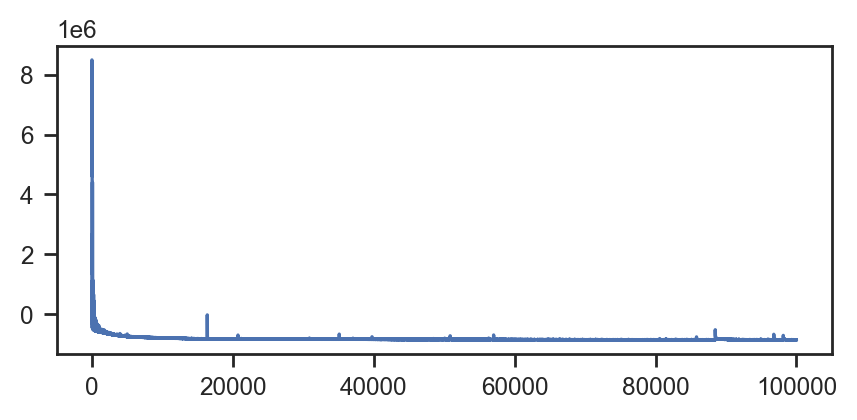

In [11]:
guide = AutoNormal(model_with_nn)
svi = SVI(model_with_nn, guide, Adam(0.01), Trace_ELBO())

svi_result = svi.run(jax.random.PRNGKey(0), 100000, img, 800, types=3)
samples_svi = guide.sample_posterior(jax.random.PRNGKey(0), svi_result.params, sample_shape=(100,))
fig, ax = plt.subplots(figsize=(5, 2))
ax.plot(svi_result.losses)

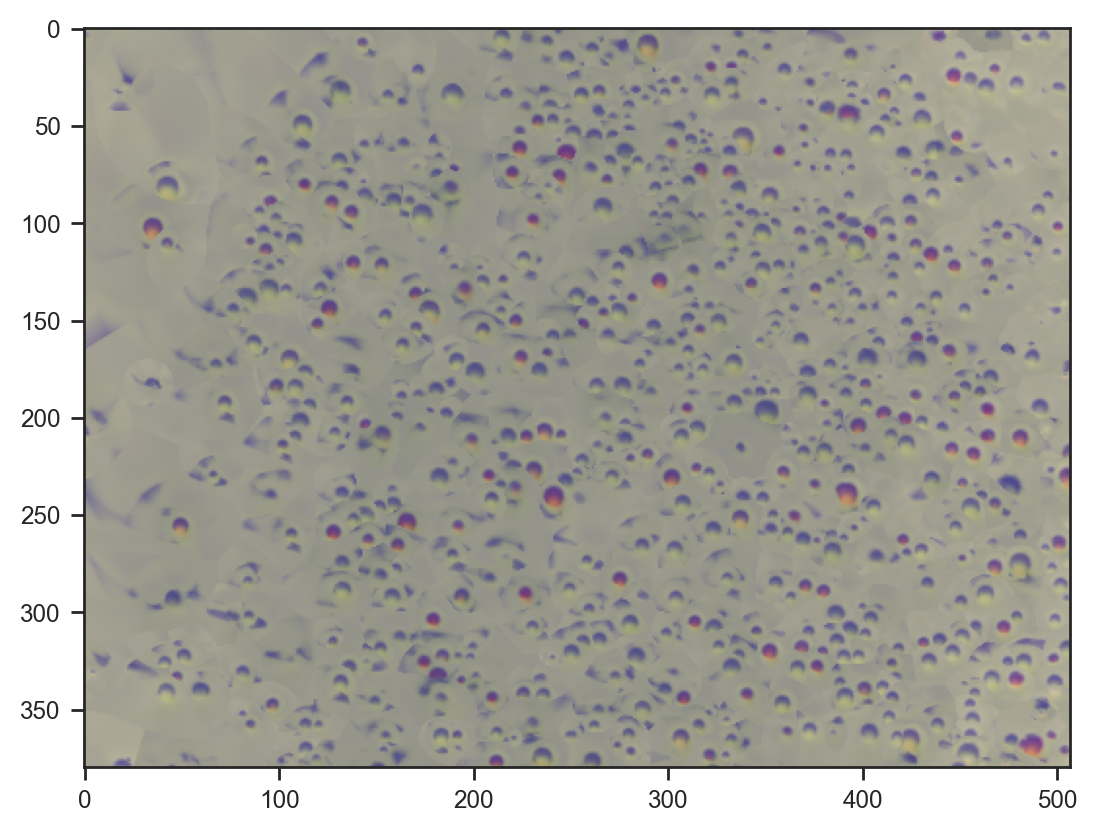

In [12]:
plt.imshow(samples_svi['prediction'].mean(axis=0))

Not a bad reconstruction, and this time we capture color as well.

In [14]:
samples_svi['composition'][:1].shape

(1, 3, 800)

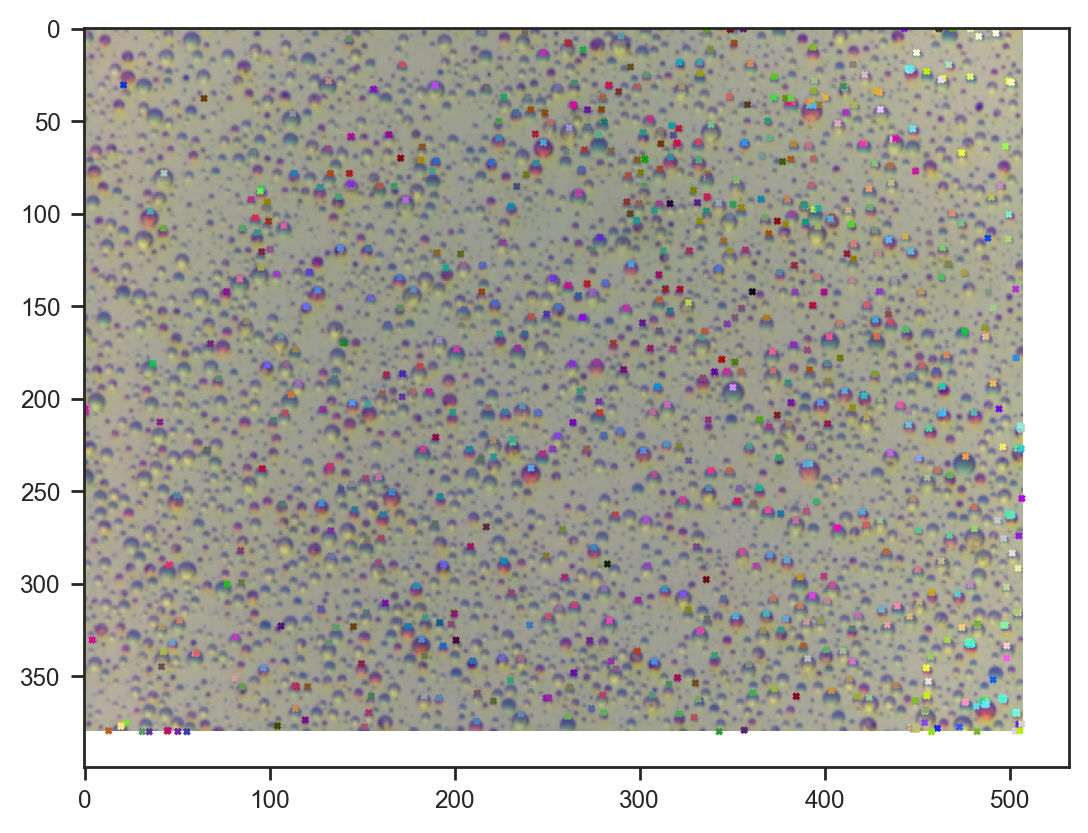

In [17]:
plt.imshow(img)

plt.scatter(samples_svi['x'][0], samples_svi['y'][0], s=4, alpha=1.0, c=samples_svi['composition'][0].T, marker='x')

Droplet composition seems nicely consistent with the image.

## Other attempts

A couple of other approaches that didn't quite work.

### Fully flattened model with aggregation

Two issues: memory use and how to aggregate the results at the end.

In [ ]:
def model_with_nn(img, n_droplets, types=10):
    h, w, n_channels = img.shape
    
    # Create coordinate grids
    y_coords, x_coords = jnp.mgrid[:h, :w]
    
    # Sample background per channel
    with plate("channels", n_channels):
        bg = sample("bg", dist.Uniform(0, 1).expand((n_channels,)))

    # Sample droplet parameters
    with plate("droplets", n_droplets):
        x = sample("x", dist.Uniform(0, w))
        y = sample("y", dist.Uniform(0, h))
        r = sample("r", dist.LogNormal(0, 0.5))
        with plate("types", types):
            composition = sample("composition", dist.Uniform(0, 1)).T

    model = DropletOpticsModel()

    # Initialize background image
    bg = jnp.broadcast_to(bg, (h, w, n_channels))
    nn_params = model.init(key, 
                           jnp.zeros((h * w, n_channels)), 
                           jnp.zeros((h * w, 1)),
                           jnp.zeros((h * w, 1)),
                           jnp.zeros((h * w, 1)),
                           jnp.zeros((h * w, types)))    
    nn_params = tree_to_dists(nn_params, path='nn_params')
    
    # Calculate relative distances from droplet center
    dx = (x_coords[..., None] - x) / r  # Normalized by radius
    dy = (y_coords[..., None] - y) / r  # Normalized by radius

    # Flatten spatial dimensions for neural network processing
    dx_flat = dx.flatten()[:, None]
    dy_flat = dy.flatten()[:, None]
    r_flat = jnp.broadcast_to(r, (h, w, n_droplets)).flatten()[:, None]
    
    # Repeat background and composition for all pixels
    bg_flat = jnp.broadcast_to(bg[:, :, None, :], (h, w, n_droplets, n_channels)).reshape(-1, n_channels)
    comp_flat = jnp.broadcast_to(composition, (h * w, n_droplets, types)).reshape(-1, types)
    
    # Apply neural network to get new pixel values
    new_pixels = model.apply(nn_params, bg_flat, dx_flat, dy_flat, r_flat, comp_flat)
    
    # Reshape back to image dimensions
    new_pixels = new_pixels.reshape(h, w, n_channels)
    
    # Update prediction (could be additive or replacement - using replacement here)
    prediction = new_pixels
    
    prediction = jnp.clip(prediction, 0, 1)
    prediction = deterministic('prediction', prediction)
    diff = deterministic('diff', img - prediction)
    sample('obs', dist.Normal(scale=0.05), obs=diff)

### Iterative with `lax.scan`

In [ ]:
def model_with_nn(img, n_droplets, types=10):
    h, w, n_channels = img.shape
    
    # Create coordinate grids
    y_coords, x_coords = jnp.mgrid[:h, :w]
    
    # Sample background per channel
    with plate("channels", n_channels):
        bg = sample("bg", dist.Uniform(0, 1).expand((n_channels,)))

    # Sample droplet parameters
    with plate("droplets", n_droplets):
        x = sample("x", dist.Uniform(0, w))
        y = sample("y", dist.Uniform(0, h))
        r = sample("r", dist.LogNormal(0, 0.5))
        with plate("types", types):
            composition = sample("composition", dist.Uniform(0, 1))

    model = DropletOpticsModel()

    # Initialize background image
    prediction = jnp.broadcast_to(bg, (h, w, n_channels))
    nn_params = model.init(key, 
                           jnp.zeros((h * w, n_channels)), 
                           jnp.zeros((h * w, 1)),
                           jnp.zeros((h * w, 1)),
                           jnp.zeros((h * w, 1)),
                           jnp.zeros((h * w, types)))    
    nn_params = tree_to_dists(nn_params, path='nn_params')
    # For each droplet, compute its effect using the neural network
    def apply_droplet(carry, droplet_params):
        current_prediction = carry
        x_i, y_i, r_i, comp_i = droplet_params
        
        # Calculate relative distances from droplet center
        dx = (x_coords - x_i) / r_i  # Normalized by radius
        dy = (y_coords - y_i) / r_i  # Normalized by radius
        
        # Flatten spatial dimensions for neural network processing
        dx_flat = dx.flatten()[:, None]
        dy_flat = dy.flatten()[:, None]
        r_flat = jnp.full((h * w, 1), r_i)
        
        # Repeat background and composition for all pixels
        bg_flat = current_prediction.reshape(-1, n_channels)
        comp_flat = jnp.broadcast_to(comp_i, (h * w, types))
        
        # Apply neural network to get new pixel values
        new_pixels = model.apply(nn_params, bg_flat, dx_flat, dy_flat, r_flat, comp_flat)
        
        # Reshape back to image dimensions
        new_pixels = new_pixels.reshape(h, w, n_channels)
        
        return new_pixels, None
    
    prediction, _ = jax.lax.scan(apply_droplet, prediction, (x, y, r, composition.T))
    prediction = jnp.clip(prediction, 0, 1)
    prediction = deterministic('prediction', prediction)
    diff = deterministic('diff', img - prediction)
    sample('obs', dist.Normal(scale=0.05), obs=diff)
    return nn_params